In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation


In [62]:
from src.modules.data_preprocessing import load_data
from src.missing_data_exploration.sub_modules.ms_simulate import mcar_simulate, mar_simulate
from src.missing_data_exploration.sub_modules import evaluation_models
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from config import ROOT_DIR, settings
import os
import json
import pandas as pd

## Function

In [86]:
data = {}
data_name = 'diabetes'
dir_name = f"{ROOT_DIR}/{settings['experiment_result_dir']}/{settings['processed_result_dir']}/ms_eval_new_0327/"
file = f"{data_name}_mcar_col_all.json"
with open(dir_name + file, 'r') as fp:
    data = json.load(fp)
df = pd.DataFrame.from_dict(data, orient='index')

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8
simple_lr,[0],"[0.010281129019350127, 0.009647410492672683, 0...","[0.016234745461201478, 0.03626878464822511, 0....","[0.04129518180683038, 0.04117615041575543, 0.0...","[0.02692942581478038, 0.08034498637048244, 0.0...","[0.13050085035915343, 0.10581056965927836, 0.0...","[0.18836973197775114, 0.1204612821454588, 0.15...","[0.26076540105782786, 0.24775633386633295, 0.2...","[0.3763270666913796, 0.3498389111402907, 0.258..."
simple_svm,[0],"[0.0232459503324806, 0.0020686554420859694, 0....","[0.019957915328460744, 0.04165802815940596, 0....","[0.056025571476913935, 0.07286523849420525, 0....","[0.047886456393351165, 0.05067653208986124, 0....","[0.13083360625729396, 0.08687813810631, 0.0587...","[0.1587675916255564, 0.08842900470055486, 0.13...","[0.12570398110578168, 0.1545866896378602, 0.11...","[0.17371963239887211, 0.15050678776210677, 0.0..."
iter_lr,[0],"[-0.002331412772143313, 0.0004523466191163358,...","[-0.002312042556055878, 0.004216512161803271, ...","[0.016104243301607216, 0.04061817376839462, 0....","[0.006343166931521474, 0.01085089732448998, 0....","[0.08139522815396097, 0.015252192288682246, 0....","[0.0585657108295481, 0.025533269794924162, 0.0...","[0.10009882443187296, 0.08175944891054773, 0.0...","[0.15320152176211163, 0.10314471024488397, 0.1..."
iter_svm,[0],"[-0.002022740891391614, 0.002474159191330147, ...","[-0.0016995310334324994, 0.017902501441471413,...","[0.023304045699910007, 0.03611921207054097, 0....","[0.04192890580765998, 0.00936395973656194, 0.0...","[0.10692438583584422, 0.03679721187710862, 0.0...","[0.06500239444613462, 0.08376719871751506, 0.0...","[0.0869339472430885, 0.1288270761060946, 0.119...","[0.16404158003312186, 0.13320497817312138, 0.1..."


In [99]:
import seaborn as sns
from matplotlib import pyplot as plt

def draw_plot_mcar(data_name, relative_error = False):
    data = {}
    dir_name = f"{ROOT_DIR}/{settings['experiment_result_dir']}/{settings['processed_result_dir']}/ms_eval_new_0327/"
    file = f"{data_name}_mcar_col_all.json"
    with open(dir_name + file, 'r') as fp:
        data = json.load(fp)
    
    # draw plot
    fig, ax = plt.subplots(figsize=(6, 4))
    df = pd.DataFrame.from_dict(data, orient='index')
    if relative_error:
        def get_relative_value(x, col):
            ret = []
            for value in x[col]:
                ret.append((value - x['0'][0]) / (x['0'][0] + 1e-6))
            return ret
        for col in ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8']:
            df[col] = df.apply(lambda x: get_relative_value(x, col), axis=1)
        df['0'] = df['0'].apply(lambda x: [0])
    df = df.T
    df.reset_index(inplace=True)
    df = pd.melt(df, id_vars=['index'], var_name='imputation_clf', value_name='rmse')
    df = df.explode('rmse')
    df.columns = ['missing_ratio', 'imputation_clf', 'rmse']
    df = df[df['imputation_clf'].isin(['iter_lr', 'iter_svm'])]

    def error_bar(x):
        return np.min(x), np.max(x)

    sns.lineplot(x='missing_ratio', y='rmse', hue='imputation_clf', data=df, markers = 'O', errorbar='sd', ax=ax)
    ax.set_title("mcar")
    ax.set_xlabel("Missing Ratio")
    if relative_error:
        ax.set_ylabel("Relative RMSE compare to 0% missing")
    else:
        ax.set_ylabel("RMSE")
    plt.tight_layout()

def draw_plot_mar(data_name, option = 'mar',relative_error = False):
    # read files and data
    data = {}
    dir_name = f"{ROOT_DIR}/{settings['experiment_result_dir']}/{settings['processed_result_dir']}/ms_eval_new_0327/"
    ms_funcs = ['left', 'right']
    ms_options = ['quantile_strict', 'sigmoid_nonstrict']
    for ms_func in ms_funcs:
        for ms_option in ms_options:
            file = f"{data_name}_{option}_{ms_option}_{ms_func}.json"
            with open(dir_name + file, 'r') as fp:
                data[f"{ms_option}_{ms_func}"] = json.load(fp)
    
    # draw plot
    plots_names = [
        ['quantile_strict_left',  'sigmoid_nonstrict_left', 'quantile_strict_right', 'sigmoid_nonstrict_right']
    ]
    fig, ax = plt.subplots(1, 4, figsize=(13, 3), sharey=True, squeeze=False)
    for i in range(1):
        for j in range(4):
            plot_name = plots_names[i][j]
            # make dataframe
            plot_data = data[plot_name]
            df = pd.DataFrame.from_dict(plot_data, orient='index')
            if relative_error:
                def get_relative_value(x, col):
                    ret = []
                    for value in x[col]:
                        ret.append((value - x['0'][0]) / (x['0'][0] + 1e-6))
                    return ret
                for col in ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8']:
                    df[col] = df.apply(lambda x: get_relative_value(x, col), axis=1)
                df['0'] = df['0'].apply(lambda x: [0])
            df = df.T
            df.reset_index(inplace=True)
            df = pd.melt(df, id_vars=['index'], var_name='imputation_clf', value_name='rmse')
            df = df.explode('rmse')
            df.columns = ['missing_ratio', 'imputation_clf', 'rmse']
            df = df[df['imputation_clf'].isin(['iter_lr', 'iter_svm'])]

            def error_bar(x):
                return np.min(x), np.max(x)

            sns.lineplot(x='missing_ratio', y='rmse', hue='imputation_clf', data=df, markers = 'O', errorbar='sd', ax=ax[i][j])
            ax[i][j].set_title(plot_name)
            ax[i][j].set_xlabel("Missing Ratio")
            if relative_error:
                ax[i][j].set_ylabel("Relative RMSE compare to 0% missing")
            else:
                ax[i][j].set_ylabel("RMSE")
    plt.tight_layout()

In [23]:
def eval_base(X_train_ms, y_train, X_test, y_test, config, seed):

    clf_seed = seed    

    X_train_imp_simple = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_ms)
    min_values, max_values = np.nanmin(X_train_ms, axis=0), np.nanmax(X_train_ms, axis=0) + 0.001
    X_train_imp_iter = IterativeImputer(
        random_state=seed, max_iter=50, min_value=min_values, max_value=max_values
    ).fit_transform(X_train_ms)


    #print("Simple Imputer")
    score_simple_lr = evaluation_models.eval_ridge(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
    score_simple_svm = evaluation_models.eval_svr(X_train_imp_simple, y_train, X_test, y_test, seed=clf_seed)
    score_iter_lr = evaluation_models.eval_ridge(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
    score_iter_svm = evaluation_models.eval_svr(X_train_imp_iter, y_train, X_test, y_test, seed=clf_seed)
    
    return score_simple_lr['rmse'], score_simple_svm['rmse'], score_iter_lr['rmse'], score_iter_svm['rmse']

In [37]:
def evaluation_mcar(
        X_train, y_train, X_test, y_test, config, col_option, ms_ratios, r_seed = 21, n_rounds = 100, 
        name = 'default', res = None
    ):

    if col_option == 'all':
        cols = list(range(X_train.shape[1]))
    elif col_option == 'important':
        cols = config['important_features_idx']
    else:
        raise NotImplemented

    for ms_ratio in ms_ratios:
        simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
        for seed in range(1, n_rounds+1):
            #print("===========================================================================================")
            # simulate missing data
            X_train_ms =  mcar_simulate.simulate_nan_mcar(X_train, cols, ms_ratio, seed)
            eval_res = eval_base(X_train_ms, y_train, X_test, y_test, config, r_seed)
            simple_lr.append(eval_res[0])
            simple_svm.append(eval_res[1])
            iter_lr.append(eval_res[2])
            iter_svm.append(eval_res[3])
        
        print("mr {} Simple lr {:.2}({:.3}) svm {:.2}({:.3}) Iter lr {:.2}({:.3}) svm {:.2}({:.3})".format(
            ms_ratio,np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm), 
            np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))
        
        # append results
        res['simple_lr'][ms_ratio] = simple_lr.copy()
        res['simple_svm'][ms_ratio] = simple_svm.copy()
        res['iter_lr'][ms_ratio] = iter_lr.copy()
        res['iter_svm'][ms_ratio] = iter_svm.copy()

    # save result to disk
    file_name = f"{name}_mcar_col_{col_option}.json"
    dir_name = f"{ROOT_DIR}/{settings['experiment_result_dir']}/{settings['processed_result_dir']}/ms_eval_new_0327/"
    os.makedirs(dir_name, exist_ok=True)
    with open(dir_name + file_name, 'w') as fp:
        json.dump(res, fp)

In [46]:
def evaluation_mar(
        X_train, y_train, X_test, y_test, config, cols, mar_option, ms_ratios, ms_func, 
        r_seed = 21, n_rounds = 100, name = 'default', res = None
    ):

    for ms_ratio in ms_ratios:
        simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
        for seed in range(1, n_rounds+1):
            #print("===========================================================================================")
            # simulate missing data
            if mar_option == 'quantile_strict':
                X_train_ms = mar_simulate.simulate_nan_mar_quantile(
                    X_train, cols, ms_ratio, ms_func, obs=True, strict = True, seed = seed)
            elif mar_option == 'quantile_nonstrict':
                X_train_ms = mar_simulate.simulate_nan_mar_quantile(
                    X_train, cols, ms_ratio, ms_func, obs=True, strict = False, seed = seed)
            elif mar_option == 'sigmoid_strict':
                X_train_ms = mar_simulate.simulate_nan_mar_sigmoid(
                    X_train, cols, ms_ratio, ms_func, obs=True, k ='all', strict = True, seed = seed)
            elif mar_option == 'sigmoid_nonstrict':
                X_train_ms = mar_simulate.simulate_nan_mar_sigmoid(
                    X_train, cols, ms_ratio, ms_func, obs=True, k = 'all', strict = False, seed = seed)
            elif mar_option == 'quantile_strict_nobs':
                X_train_ms = mar_simulate.simulate_nan_mar_quantile(
                    X_train, cols, ms_ratio, ms_func, obs=False, strict = True, seed = seed)
            elif mar_option == 'quantile_nonstrict_nobs':
                X_train_ms = mar_simulate.simulate_nan_mar_quantile(
                    X_train, cols, ms_ratio, ms_func, obs=False, strict = False, seed = seed)
            elif mar_option == 'sigmoid_strict_nobs':
                X_train_ms = mar_simulate.simulate_nan_mar_sigmoid(
                    X_train, cols, ms_ratio, ms_func, obs=False, k = 'all', strict = True, seed = seed)
            elif mar_option == 'sigmoid_nonstrict_nobs':
                X_train_ms = mar_simulate.simulate_nan_mar_sigmoid(
                    X_train, cols, ms_ratio, ms_func, obs=False, k = 'all', strict = False, seed = seed)
            else:
                raise ValueError("mar_option not supported")

            # imputation and evaluation
            eval_res = eval_base(X_train_ms, y_train, X_test, y_test, config, r_seed)
            simple_lr.append(eval_res[0])
            simple_svm.append(eval_res[1])
            iter_lr.append(eval_res[2])
            iter_svm.append(eval_res[3])
        
        print("mr {} Simple lr {:.2}({:.3}) svm {:.2}({:.3}) Iter lr {:.2}({:.3}) svm {:.2}({:.3})".format(
            ms_ratio,np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm), 
            np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))
        
        # append results
        res['simple_lr'][ms_ratio] = simple_lr.copy()
        res['simple_svm'][ms_ratio] = simple_svm.copy()
        res['iter_lr'][ms_ratio] = iter_lr.copy()
        res['iter_svm'][ms_ratio] = iter_svm.copy()

    # save result to disk
    file_name = f"{name}_mar_{mar_option}_{ms_func}.json"
    dir_name = f"{ROOT_DIR}/{settings['experiment_result_dir']}/{settings['processed_result_dir']}/ms_eval_new_0327/"
    os.makedirs(dir_name, exist_ok=True)
    with open(dir_name + file_name, 'w') as fp:
        json.dump(res, fp)

In [54]:
def evaluation_mary(
        X_train, y_train, X_test, y_test, config, cols, mary_option, ms_ratios, ms_func, r_seed = 21, 
        n_rounds = 100, name = 'default', res = None
    ):

    for ms_ratio in ms_ratios:
        simple_lr, simple_svm, iter_lr, iter_svm = [], [], [], []
        train_data = np.concatenate((X_train, y_train.reshape(-1,1)), axis = 1)
        for seed in range(1, n_rounds+1):
            #print("===========================================================================================")
            # simulate missing data
            if mary_option == 'quantile_strict':
                train_ms = mar_simulate.simulate_nan_mary_quantile(train_data, cols, ms_ratio, ms_func, strict = True, seed = seed)
            elif mary_option == 'quantile_nonstrict':
                train_ms = mar_simulate.simulate_nan_mary_quantile(train_data, cols, ms_ratio, ms_func, strict = False, seed = seed)
            elif mary_option == 'sigmoid_strict':
                train_ms = mar_simulate.simulate_nan_mary_sigmoid(train_data, cols, ms_ratio, ms_func, strict = True, seed = seed)
            elif mary_option == 'sigmoid_nonstrict':
                train_ms = mar_simulate.simulate_nan_mary_sigmoid(train_data, cols, ms_ratio, ms_func, strict = False, seed = seed)
            else:
                raise ValueError("mar_option not supported")
            X_train_ms = train_ms[:, :-1]

            # imputation and evaluation
            eval_res = eval_base(X_train_ms, y_train, X_test, y_test, config, r_seed)
            simple_lr.append(eval_res[0])
            simple_svm.append(eval_res[1])
            iter_lr.append(eval_res[2])
            iter_svm.append(eval_res[3])
        
        print("mr {} Simple lr {:.2}({:.3}) svm {:.2}({:.3}) Iter lr {:.2}({:.3}) svm {:.2}({:.3})".format(
            ms_ratio,np.mean(simple_lr), np.std(simple_lr), np.mean(simple_svm), np.std(simple_svm), 
            np.mean(iter_lr), np.std(iter_lr), np.mean(iter_svm), np.std(iter_svm)))
        
        # append results
        res['simple_lr'][ms_ratio] = simple_lr.copy()
        res['simple_svm'][ms_ratio] = simple_svm.copy()
        res['iter_lr'][ms_ratio] = iter_lr.copy()
        res['iter_svm'][ms_ratio] = iter_svm.copy()

    # save result to disk
    file_name = f"{name}_mary_{mary_option}_{ms_func}.json"
    dir_name = f"{ROOT_DIR}/{settings['experiment_result_dir']}/{settings['processed_result_dir']}/ms_eval_new_0327/"
    os.makedirs(dir_name, exist_ok=True)
    with open(dir_name + file_name, 'w') as fp:
        json.dump(res, fp)

In [50]:
def eval_data(dataset_name, missing_ratios, n_rounds, ms_mechs, seed = 21):
    data, config = load_data(dataset_name)
    print(data.columns)
    print(config)
    seed = seed
    train_data, test_data = train_test_split(data, test_size=0.15, random_state=seed, shuffle=True)
    print(train_data.shape, test_data.shape)

    # evaluation full
    clf_seed = seed
    res = {'simple_lr': {}, 'simple_svm': {}, 'iter_lr': {}, 'iter_svm': {}}
    
    # evaluation on full data
    X_train = train_data.drop(config['target'], axis=1).values
    y_train = train_data[config['target']].values
    X_test = test_data.drop(config['target'], axis=1).values
    y_test = test_data[config['target']].values

    lr_full = evaluation_models.eval_ridge(X_train, y_train, X_test, y_test, seed=clf_seed)
    svm_full = evaluation_models.eval_svr(X_train, y_train, X_test, y_test, seed=clf_seed)
    res['simple_lr'][0] = [lr_full['rmse']]
    res['simple_svm'][0] = [svm_full['rmse']]
    res['iter_lr'][0] = [lr_full['rmse']]
    res['iter_svm'][0] = [svm_full['rmse']]

    for mech in ms_mechs:
        if mech == 'mcar':
            # mcar
            print("-----------------------------------mcar------------------------------------------")
            evaluation_mcar(
                X_train, y_train, X_test, y_test, config, 'all', missing_ratios, 
                r_seed = seed, n_rounds = n_rounds, name = dataset_name, res = res)
        elif mech == 'mar':
            # mar
            cols_mar = config['important_features_idx']
            if len(cols_mar) == data.shape[1] - 1:
                cols_mar = cols_mar[:-1]
            for mar_option in ['quantile_strict', 'quantile_nonstrict', 'sigmoid_strict', 'sigmoid_nonstrict']:
                for ms_func in ['left', 'right']:
                    print("-----------------------------------{}_{}------------------------------------------".
                    format(mar_option, ms_func))
                    evaluation_mar(X_train, y_train, X_test, y_test, config, 
                        cols_mar, mar_option, missing_ratios, ms_func = ms_func, 
                        r_seed = seed, n_rounds = n_rounds, name = dataset_name, res= res)
        elif mech == 'mary':
            # mary
            cols_mary = config['features_idx']
            for mar_option in ['quantile_strict', 'quantile_nonstrict', 'sigmoid_strict', 'sigmoid_nonstrict']:
                for ms_func in ['left', 'right']:
                    print("-----------------------------------{}_{}------------------------------------------".
                    format(mar_option, ms_func))
                    evaluation_mary(X_train, y_train, X_test, y_test, config, 
                        cols_mary, mar_option, missing_ratios, ms_func = ms_func, 
                        r_seed = seed, n_rounds = n_rounds, name = dataset_name, res= res)


## Diabetes

In [ ]:
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
seed = 21
eval_data('diabetes', missing_ratios, n_rounds = 10, ms_mechs = ['mcar'], seed = seed)

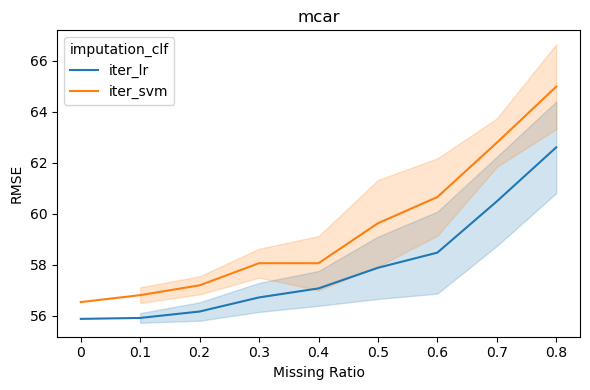

In [65]:
draw_plot_mcar('diabetes')

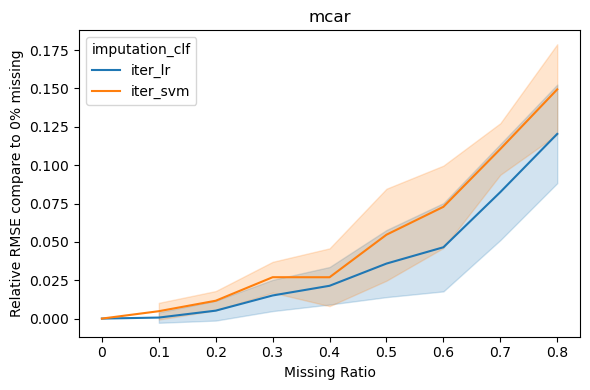

In [97]:
draw_plot_mcar('diabetes', relative_error = True)

In [44]:
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
seed = 21
eval_data('diabetes', missing_ratios, n_rounds = 10, ms_mechs = ['mar'], seed = seed)

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')
{'target': 'target', 'important_features_idx': [2, 8, 3, 7, 6, 9, 4, 0, 5], 'important_features': ['bmi', 's5', 'bp', 's4', 's3', 's6', 's1', 'age', 's2'], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'num_cols': 10, 'task_type': 'regression'}
(375, 11) (67, 11)
-----------------------------------quantile_strictleft------------------------------------------
mr 0.1 Simple lr 5.7e+01(0.252) svm 5.8e+01(0.587) Iter lr 5.6e+01(0.215) svm 5.7e+01(0.213)
mr 0.2 Simple lr 5.8e+01(0.403) svm 5.9e+01(0.556) Iter lr 5.6e+01(0.454) svm 5.7e+01(0.343)
mr 0.3 Simple lr 5.9e+01(0.691) svm 6.1e+01(0.686) Iter lr 5.6e+01(0.566) svm 5.7e+01(0.7)
mr 0.4 Simple lr 6e+01(0.778) svm 6.2e+01(0.853) Iter lr 5.6e+01(0.308) svm 5.8e+01(0.498)
mr 0.5 Simple lr 6.1e+01(0.47) svm 6.3e+01(0.59) Iter lr 5.7e+01(0.84) svm 5.8e+01(1.25)
mr 0.6 Simple lr 6.3e+01(1.11) svm 6.5e+01(1.05) Iter lr 6.1e+01(0.744

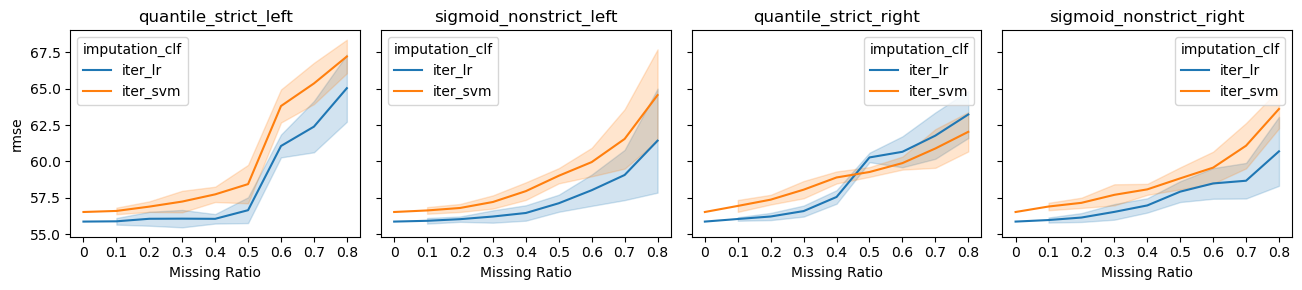

In [68]:
draw_plot_mar('diabetes', option = 'mar')

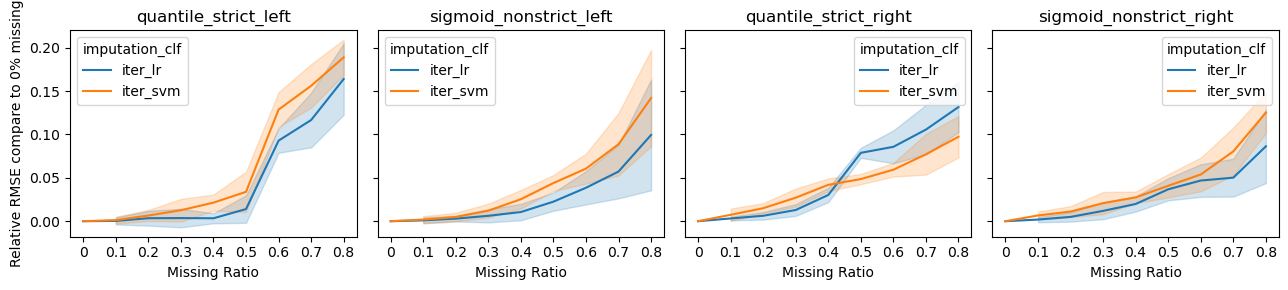

In [100]:
draw_plot_mar('diabetes', option = 'mar', relative_error = True)

In [55]:
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
seed = 21
eval_data('diabetes', missing_ratios, n_rounds = 10, ms_mechs = ['mary'], seed = seed)

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')
{'target': 'target', 'important_features_idx': [2, 8, 3, 7, 6, 9, 4, 0, 5], 'important_features': ['bmi', 's5', 'bp', 's4', 's3', 's6', 's1', 'age', 's2'], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'num_cols': 10, 'task_type': 'regression'}
(375, 11) (67, 11)
-----------------------------------quantile_strict_left------------------------------------------
mr 0.1 Simple lr 5.6e+01(7.11e-15) svm 5.7e+01(7.11e-15) Iter lr 5.6e+01(7.11e-15) svm 5.7e+01(7.11e-15)
mr 0.2 Simple lr 5.7e+01(0.0) svm 5.7e+01(7.11e-15) Iter lr 5.7e+01(7.11e-15) svm 5.7e+01(7.11e-15)
mr 0.3 Simple lr 5.9e+01(0.0529) svm 5.9e+01(0.0576) Iter lr 5.9e+01(0.0271) svm 5.9e+01(0.0312)
mr 0.4 Simple lr 6.1e+01(1.42e-14) svm 6.5e+01(0.0) Iter lr 6.1e+01(1.42e-14) svm 6.5e+01(0.0)
mr 0.5 Simple lr 6.7e+01(0.0733) svm 7.4e+01(1.03e-07) Iter lr 6.7e+01(0.0658) svm 7.4e+01(0.0114)
mr 0.6 Simple lr 6.8e+01(0.0) 

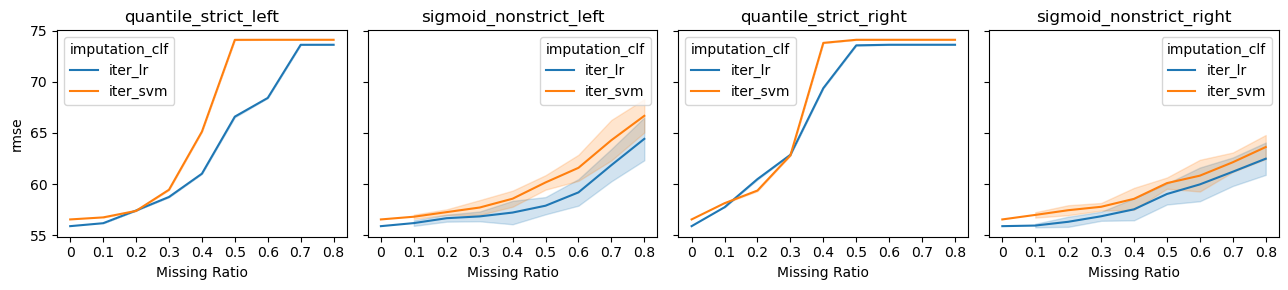

In [69]:
draw_plot_mar('diabetes', option = 'mary')

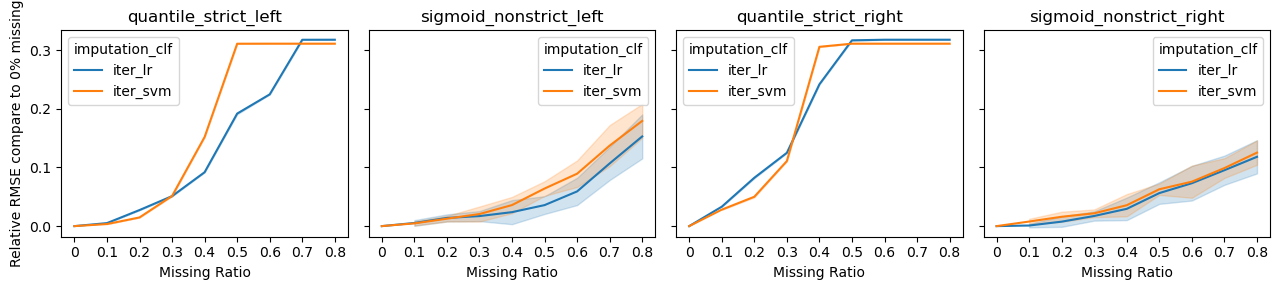

In [101]:
draw_plot_mar('diabetes', option = 'mary', relative_error = True)

## California Housing

In [20]:
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
seed = 21
eval_data('california_housing', missing_ratios, seed = seed)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')
{'target': 'MedHouseVal', 'important_features_idx': [0, 2, 5, 6], 'important_features': ['MedInc', 'AveRooms', 'AveOccup', 'Latitude'], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7], 'num_cols': 8, 'task_type': 'regression'}
(850, 9) (150, 9)
mr 0.1 Simple lr 0.72(0.00648) svm 0.7(0.014) Iter lr 0.69(0.00489) svm 0.65(0.0133)
mr 0.2 Simple lr 0.74(0.00882) svm 0.71(0.0112) Iter lr 0.69(0.00701) svm 0.66(0.0224)
mr 0.3 Simple lr 0.75(0.00554) svm 0.73(0.0117) Iter lr 0.7(0.0156) svm 0.71(0.0353)
mr 0.4 Simple lr 0.76(0.0073) svm 0.77(0.0394) Iter lr 0.72(0.0171) svm 0.74(0.0772)
mr 0.5 Simple lr 0.77(0.0204) svm 0.78(0.041) Iter lr 0.75(0.0554) svm 0.76(0.0398)
mr 0.6 Simple lr 0.79(0.0299) svm 0.82(0.0422) Iter lr 0.76(0.0392) svm 0.82(0.103)
mr 0.7 Simple lr 0.81(0.031) svm 0.88(0.0536) Iter lr 0.79(0.0323) svm 0.84(0.081)
mr 0.8 Simple lr 0.

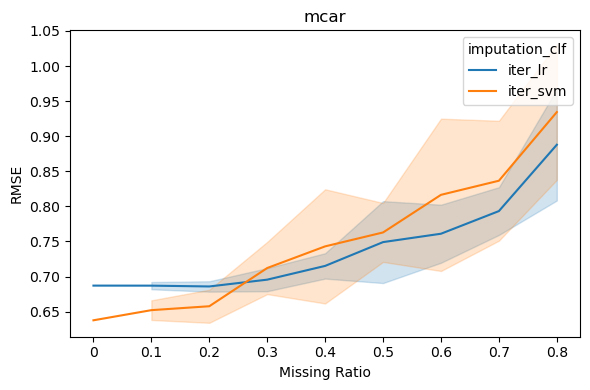

In [70]:
draw_plot_mcar('california_housing')

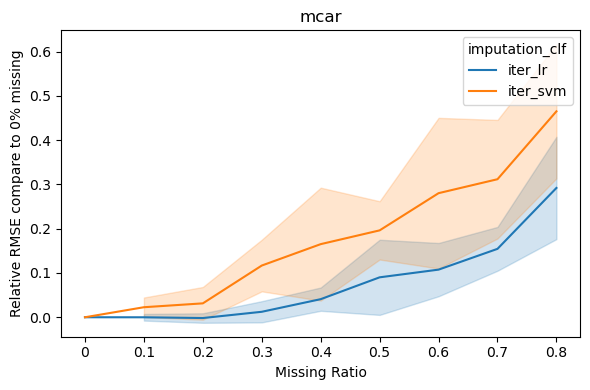

In [102]:
draw_plot_mcar('california_housing', relative_error = True)

In [56]:
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
seed = 21
eval_data('california_housing', missing_ratios, n_rounds = 5, ms_mechs = ['mar'], seed = seed)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')
{'target': 'MedHouseVal', 'important_features_idx': [0, 2, 5, 6], 'important_features': ['MedInc', 'AveRooms', 'AveOccup', 'Latitude'], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7], 'num_cols': 8, 'task_type': 'regression'}
(850, 9) (150, 9)
-----------------------------------quantile_strict_left------------------------------------------
mr 0.1 Simple lr 0.75(0.000699) svm 0.73(0.000231) Iter lr 0.69(2.98e-05) svm 0.65(0.000987)
mr 0.2 Simple lr 0.74(0.000135) svm 0.74(0.000669) Iter lr 0.72(0.000492) svm 0.69(0.00147)
mr 0.3 Simple lr 0.8(0.000727) svm 0.85(0.00326) Iter lr 0.74(0.00153) svm 0.74(0.00259)
mr 0.4 Simple lr 0.88(0.00167) svm 1.4(0.0153) Iter lr 0.92(0.00212) svm 0.84(0.00261)
mr 0.5 Simple lr 0.77(0.0) svm 0.9(1.11e-16) Iter lr 1.4(0.0) svm 1.0(0.0)
mr 0.6 Simple lr 0.81(0.00278) svm 0.85(0.0165) Iter lr 1.1(0.00325) svm 0.95(

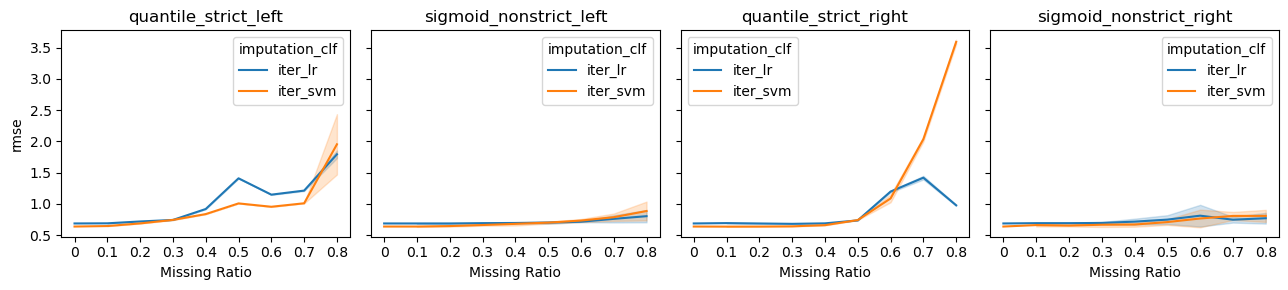

In [71]:
draw_plot_mar('california_housing', option = 'mar')

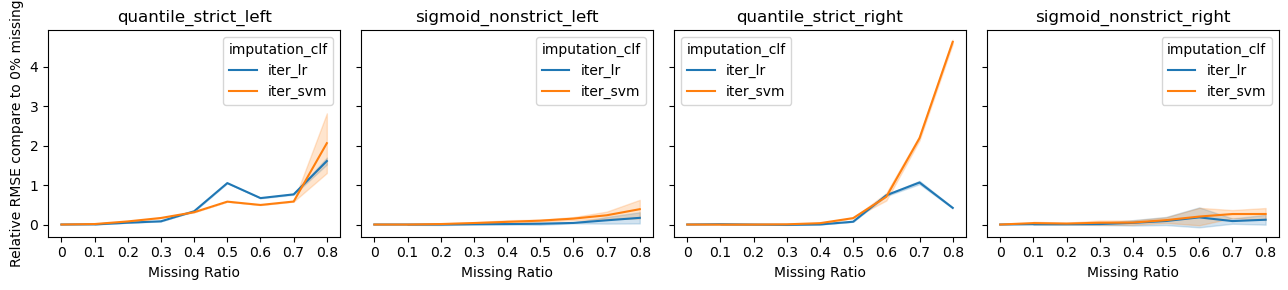

In [103]:
draw_plot_mar('california_housing', option = 'mar', relative_error = True)

In [57]:
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
seed = 21
eval_data('california_housing', missing_ratios, n_rounds = 5, ms_mechs = ['mary'], seed = seed)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')
{'target': 'MedHouseVal', 'important_features_idx': [0, 2, 5, 6], 'important_features': ['MedInc', 'AveRooms', 'AveOccup', 'Latitude'], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7], 'num_cols': 8, 'task_type': 'regression'}
(850, 9) (150, 9)
-----------------------------------quantile_strict_left------------------------------------------
mr 0.1 Simple lr 0.7(0.0) svm 0.65(0.0) Iter lr 0.7(0.0) svm 0.65(0.0)
mr 0.2 Simple lr 0.73(0.0) svm 0.78(0.0) Iter lr 0.73(0.0) svm 0.78(0.0)
mr 0.3 Simple lr 0.78(0.0) svm 0.87(0.0) Iter lr 0.78(0.0) svm 0.87(1.11e-16)
mr 0.4 Simple lr 0.84(0.0) svm 0.97(0.0) Iter lr 0.84(0.0) svm 0.97(1.11e-16)
mr 0.5 Simple lr 0.9(1.11e-16) svm 0.96(0.0) Iter lr 0.9(0.0) svm 0.96(0.0)
mr 0.6 Simple lr 1.0(0.0) svm 1.4(0.0) Iter lr 1.0(0.0) svm 1.4(0.0)
mr 0.7 Simple lr 1.0(0.0) svm 1.5(0.0) Iter lr 1.0(0.0) svm 1.5(0.0)


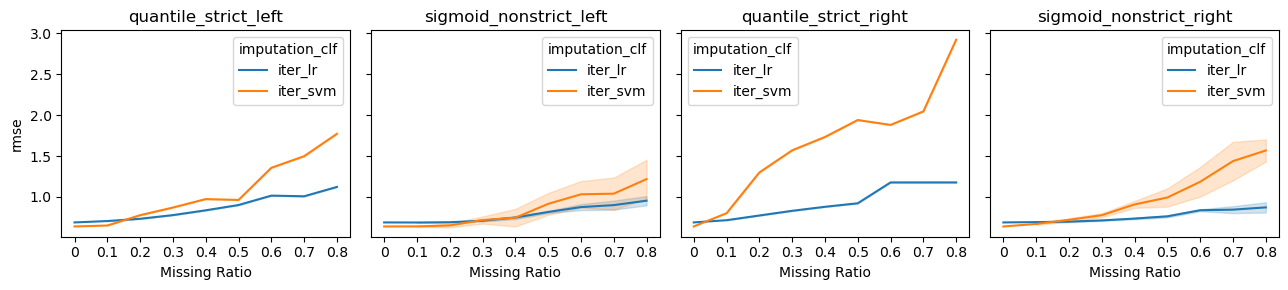

In [73]:
draw_plot_mar('california_housing', option = 'mary')

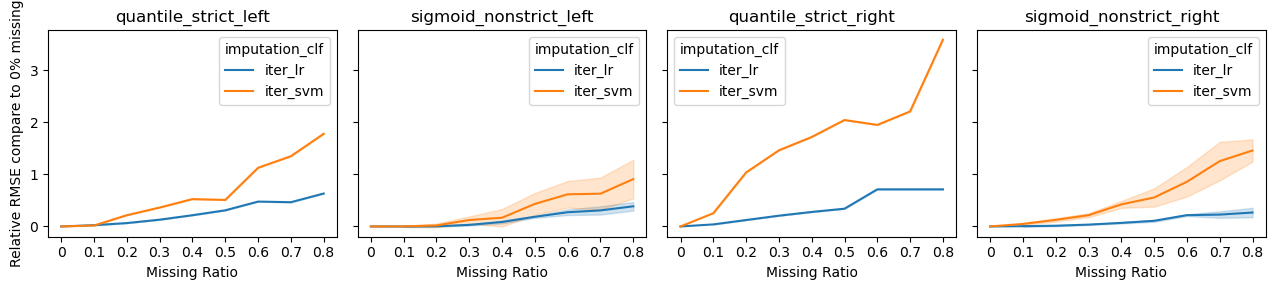

In [104]:
draw_plot_mar('california_housing', option = 'mary', relative_error = True)

## Housing

In [21]:
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
seed = 21
eval_data('housing', missing_ratios, seed = seed)

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14'],
      dtype='object')
{'target': '14', 'important_features_idx': [12, 5, 10, 2, 9, 4, 0, 8, 6, 1, 11, 7], 'important_features': ['13', '6', '11', '3', '10', '5', '1', '9', '7', '2', '12', '8'], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'num_cols': 13, 'task_type': 'regression'}
(430, 14) (76, 14)
mr 0.1 Simple lr 5.8(0.0755) svm 4.4(0.113) Iter lr 5.7(0.0408) svm 4.3(0.0814)
mr 0.2 Simple lr 5.9(0.121) svm 4.8(0.304) Iter lr 5.7(0.089) svm 4.5(0.059)
mr 0.3 Simple lr 6.2(0.157) svm 5.1(0.397) Iter lr 6.0(0.135) svm 4.9(0.223)
mr 0.4 Simple lr 6.5(0.182) svm 5.2(0.305) Iter lr 6.0(0.164) svm 5.0(0.226)
mr 0.5 Simple lr 7.2(0.32) svm 6.0(0.425) Iter lr 6.0(0.168) svm 5.2(0.298)
mr 0.6 Simple lr 8.2(0.501) svm 6.8(0.465) Iter lr 6.1(0.18) svm 5.4(0.259)
mr 0.7 Simple lr 1e+01(0.5) svm 8.9(0.838) Iter lr 6.3(0.4) svm 6.1(0.405)
mr 0.8 Simple lr 1.4e+01(0.859) svm 1.2e+01(1.46) Iter l

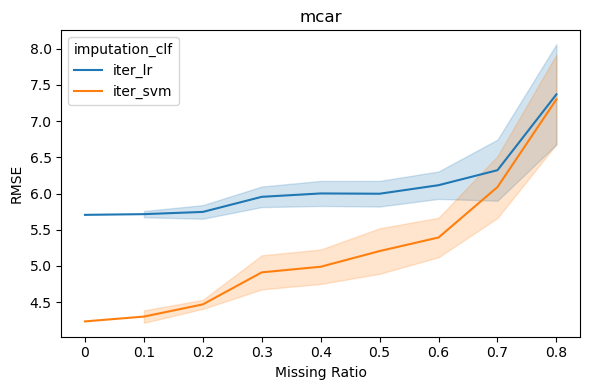

In [74]:
draw_plot_mcar('housing')

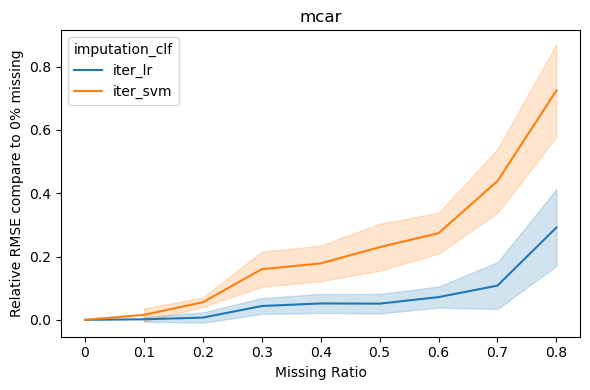

In [105]:
draw_plot_mcar('housing', relative_error = True)

In [45]:
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
seed = 21
eval_data('housing', missing_ratios, n_rounds = 10, ms_mechs = ['mar'], seed = seed)

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14'],
      dtype='object')
{'target': '14', 'important_features_idx': [12, 5, 10, 2, 9, 4, 0, 8, 6, 1, 11, 7], 'important_features': ['13', '6', '11', '3', '10', '5', '1', '9', '7', '2', '12', '8'], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'num_cols': 13, 'task_type': 'regression'}
(430, 14) (76, 14)
-----------------------------------quantile_strictleft------------------------------------------
mr 0.1 Simple lr 5.7(0.0731) svm 4.4(0.0952) Iter lr 5.7(0.0591) svm 4.2(0.106)
mr 0.2 Simple lr 5.9(0.0979) svm 4.5(0.121) Iter lr 5.8(0.09) svm 4.3(0.0998)
mr 0.3 Simple lr 6.1(0.14) svm 4.8(0.181) Iter lr 6.1(0.19) svm 4.6(0.174)
mr 0.4 Simple lr 6.5(0.163) svm 5.3(0.254) Iter lr 6.3(0.402) svm 5.1(0.194)
mr 0.5 Simple lr 7.2(0.111) svm 5.9(0.336) Iter lr 6.4(0.371) svm 5.4(0.369)
mr 0.6 Simple lr 8.0(0.325) svm 7.5(0.571) Iter lr 6.6(0.44) svm 5.7(0.352)
mr 0.7 Simple lr 8.8(0.413) svm 9.

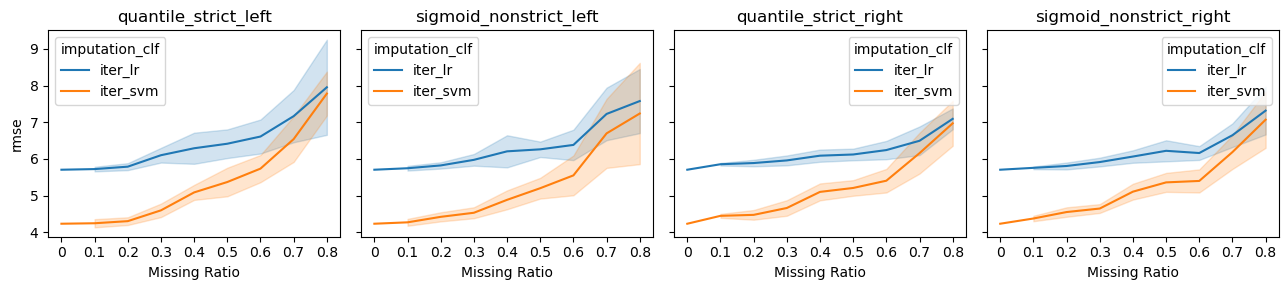

In [75]:
draw_plot_mar('housing', option = 'mar')

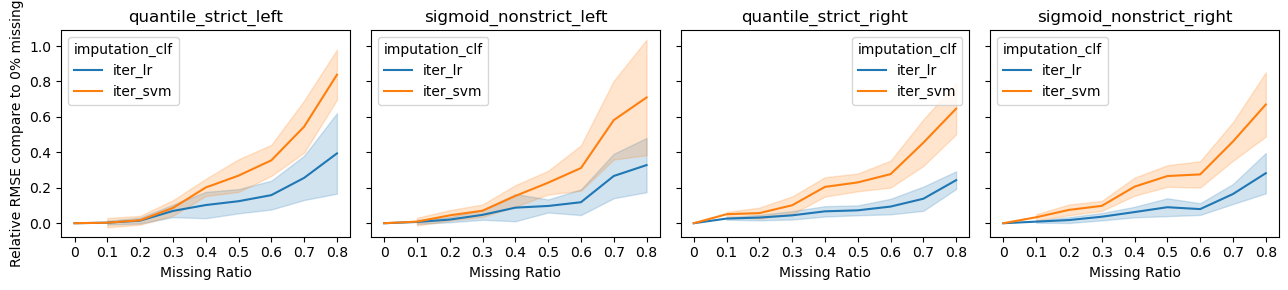

In [106]:
draw_plot_mar('housing', option = 'mar', relative_error = True)

In [58]:
missing_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
seed = 21
eval_data('housing', missing_ratios, n_rounds = 10, ms_mechs = ['mary'], seed = seed)

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14'],
      dtype='object')
{'target': '14', 'important_features_idx': [12, 5, 10, 2, 9, 4, 0, 8, 6, 1, 11, 7], 'important_features': ['13', '6', '11', '3', '10', '5', '1', '9', '7', '2', '12', '8'], 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'num_cols': 13, 'task_type': 'regression'}
(430, 14) (76, 14)
-----------------------------------quantile_strict_left------------------------------------------
mr 0.1 Simple lr 5.8(0.00444) svm 4.5(0.0153) Iter lr 5.8(0.00203) svm 4.5(0.0188)
mr 0.2 Simple lr 6.0(0.0) svm 5.2(8.88e-16) Iter lr 6.0(0.0) svm 5.2(0.0)
mr 0.3 Simple lr 6.6(0.00625) svm 6.7(0.0164) Iter lr 6.6(0.0074) svm 6.7(0.0204)
mr 0.4 Simple lr 7.0(8.88e-16) svm 7.5(0.0) Iter lr 7.0(0.0) svm 7.5(8.88e-16)
mr 0.5 Simple lr 7.6(0.0123) svm 7.9(0.0477) Iter lr 7.6(0.00898) svm 7.9(0.0625)
mr 0.6 Simple lr 8.4(1.78e-15) svm 8.7(0.0) Iter lr 8.4(0.0) svm 8.7(0.0)
mr 0.7 Simple lr 9.1(0

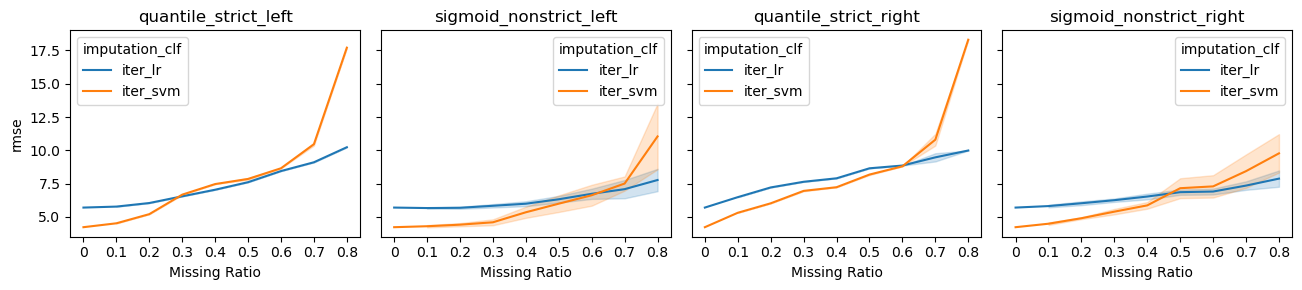

In [76]:
draw_plot_mar('housing', option = 'mary')

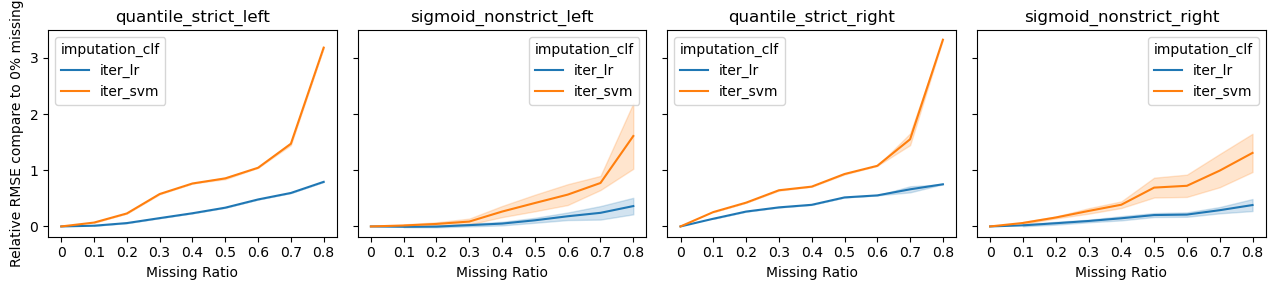

In [107]:
draw_plot_mar('housing', option = 'mary', relative_error = True)

## Iris feature as target